In [63]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [2]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [3]:
# load questions (to be removed)

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [4]:
%%time

# load processed data

import os
import pickle

# prefix = './tablellama10runs/' # 10 runs on the first 100 prompts
prefix = './644sample/' # 4 runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0

outlist = []
for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            for pid, item in enumerate(outlist_):
                if 'run' not in item: item['run'] = pid
                if 'pid' not in item: item['pid'] = pid
                outlist.append(item)
            # default (if ids do not exists)
            #outlist.extend([dict(item, **{'run': run, 'pid': pid}) for pid, item in enumerate(outlist_)])
    run += 1

len(outlist)

644.data.pickle
CPU times: user 32.6 s, sys: 4.46 s, total: 37.1 s
Wall time: 37.2 s


2752

### check output against ground truth

In [5]:
%%time

# show results

c=0
t=0
h=0

truth = []

for idx, p in enumerate(outlist):
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct))

Token indices sequence length is longer than the specified maximum sequence length for this model (6471 > 4096). Running this sequence through the model will result in indexing errors


CPU times: user 20.9 s, sys: 649 ms, total: 21.6 s
Wall time: 23.4 s


In [6]:
# true, hallucinated, counted
t, h, c

(1887, 90, 2752)

In [7]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct'])

<Axes: xlabel='correct', ylabel='Count'>

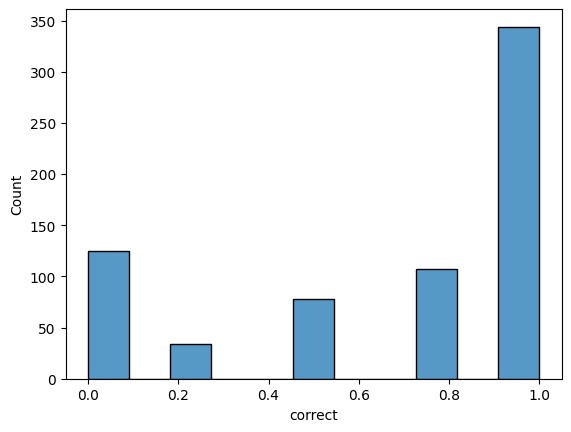

In [8]:
sns.histplot(truth.groupby('pid').correct.mean())

In [9]:
truth.groupby('pid').size().value_counts()

4    688
Name: count, dtype: int64

In [10]:
accu = truth.groupby('pid').correct.mean()

In [11]:
accu[accu<1.].shape

(344,)

In [12]:
accu.value_counts()

correct
1.00    344
0.00    125
0.75    107
0.50     78
0.25     34
Name: count, dtype: int64

### sequence components alignment
### (build "segments" for each sequence)

In [13]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [14]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 48.7 s, sys: 455 ms, total: 49.1 s
Wall time: 48.9 s


In [15]:
# check the checks (must be False)
'False' in checks

False

In [16]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [17]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [18]:
segments

,run,pid,start,end,segment,seq
0,0,9,0,40,preamble,0
1,0,9,41,135,instruction,1
2,0,9,136,5117,input,2
3,0,9,5118,6405,question,3
4,0,9,6406,6470,postilla,4
...,...,...,...,...,...,...
16507,6,1797,41,135,instruction,1
16508,6,1797,136,859,input,2
16509,6,1797,860,5398,question,3
16510,6,1797,5399,5463,postilla,4


### collect observables

In [19]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

CPU times: user 6.86 s, sys: 123 ms, total: 6.99 s
Wall time: 6.99 s


In [20]:
import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

In [21]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [22]:
%%time

# attach prompt section
m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 3.61 s, sys: 1.48 s, total: 5.1 s
Wall time: 5.29 s


In [23]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0
...,...,...,...,...,...,...,...,...,...,...,...
55012031,6,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5
55012037,6,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5
55012043,6,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5
55012049,6,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5


In [24]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [25]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

### token position normalization

In [26]:
segments['length'] = segments.end - segments.start

In [27]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.012028,0.012028
2,instruction,1,94.000000,0.000000,94,94,0.028265,0.040293
1,input,2,1825.149709,1572.718340,141,6987,0.548811,0.589104
5,question,3,1277.675872,399.434258,79,4543,0.384189,0.973294
3,postilla,4,64.000000,0.000000,64,64,0.019244,0.992538
0,generated,5,24.815407,5.911077,12,56,0.007462,1.000000


<Axes: xlabel='length', ylabel='Count'>

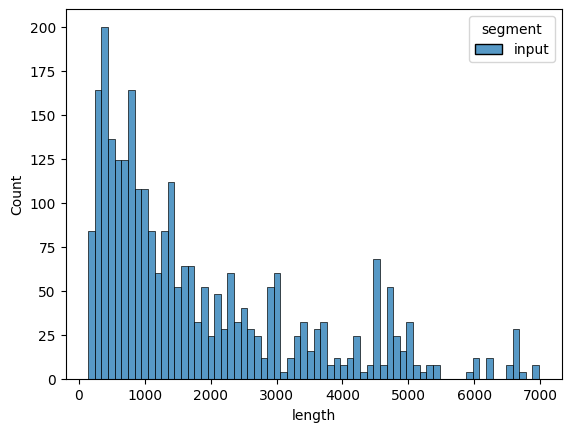

In [28]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='segment', ylabel='length'>

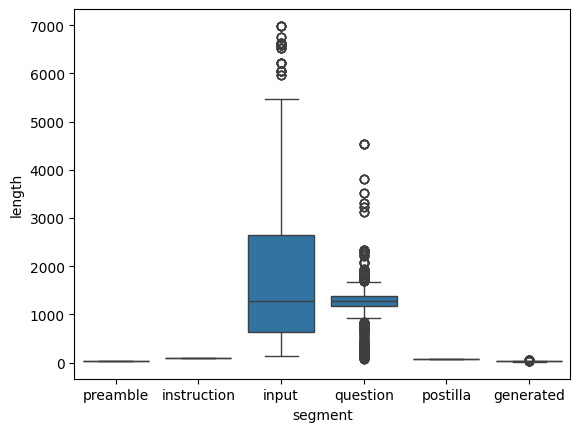

In [29]:
sns.boxplot(segments, y='length', x='segment')

In [30]:
# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

In [31]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### check variances

In [32]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [33]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [34]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [35]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [36]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.28828123

In [37]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.043671735

In [38]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00060769863

In [39]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [40]:
mm = m.copy()

### single run plots

In [41]:
m = mm[mm.run==0].copy()

In [42]:
m.groupby(['run', 'pid']).tok.size()

run  pid 
0    9       6504
     10      6517
     12      2096
     14      1552
     17      2006
             ... 
     1788    7210
     1789    6370
     1790    7445
     1794    2106
     1797    5488
Name: tok, Length: 688, dtype: int64

In [43]:
NUM_BINS = 100

100


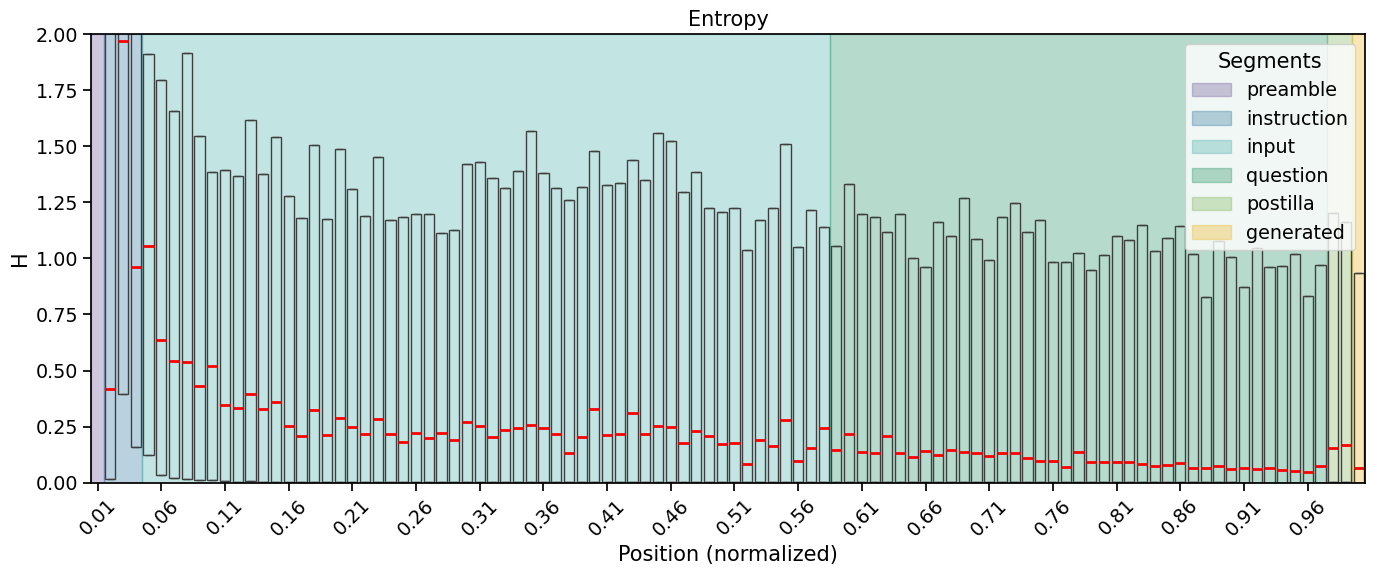

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [71]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


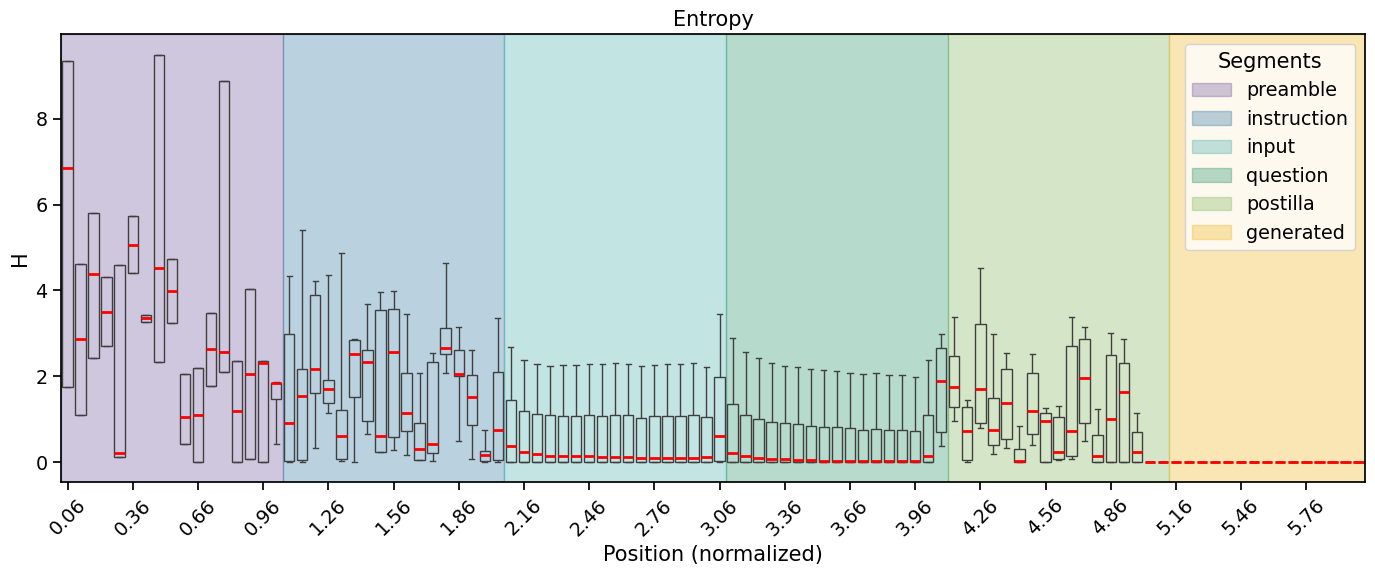

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [89]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

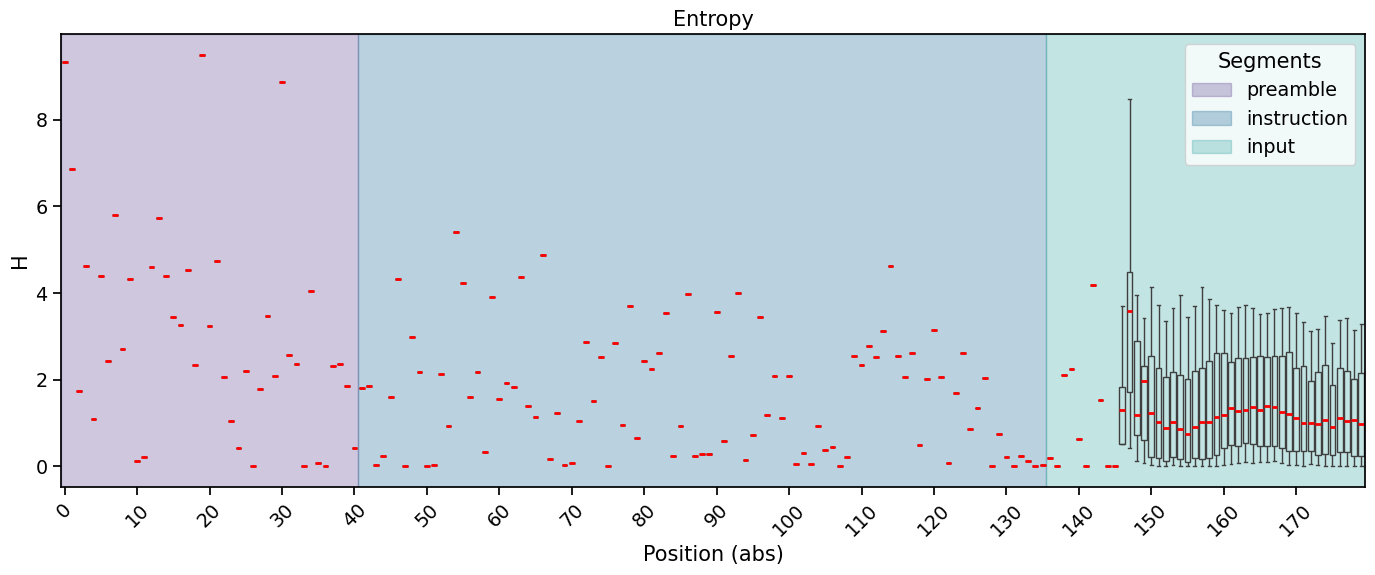

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [91]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

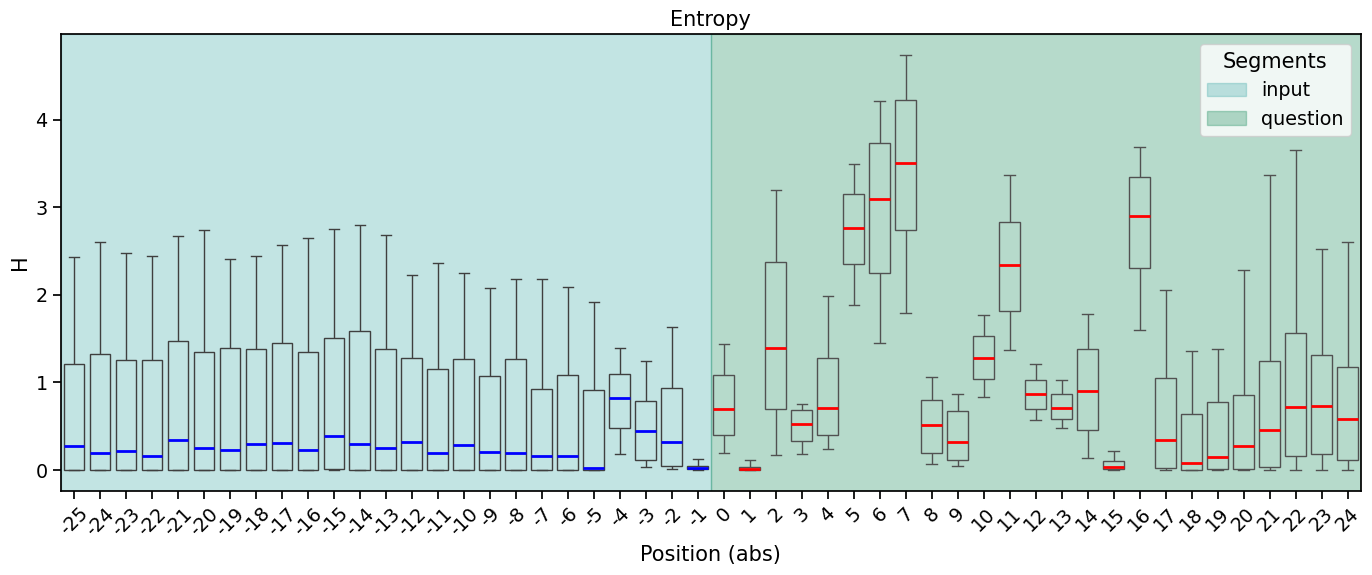

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [93]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

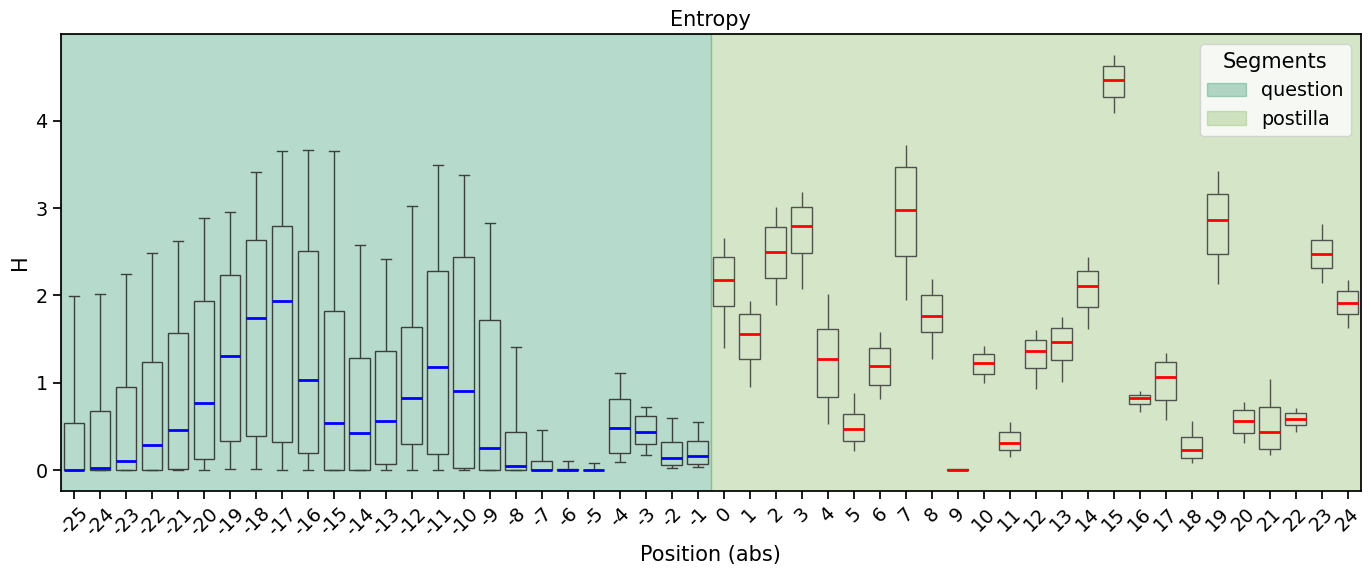

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [95]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

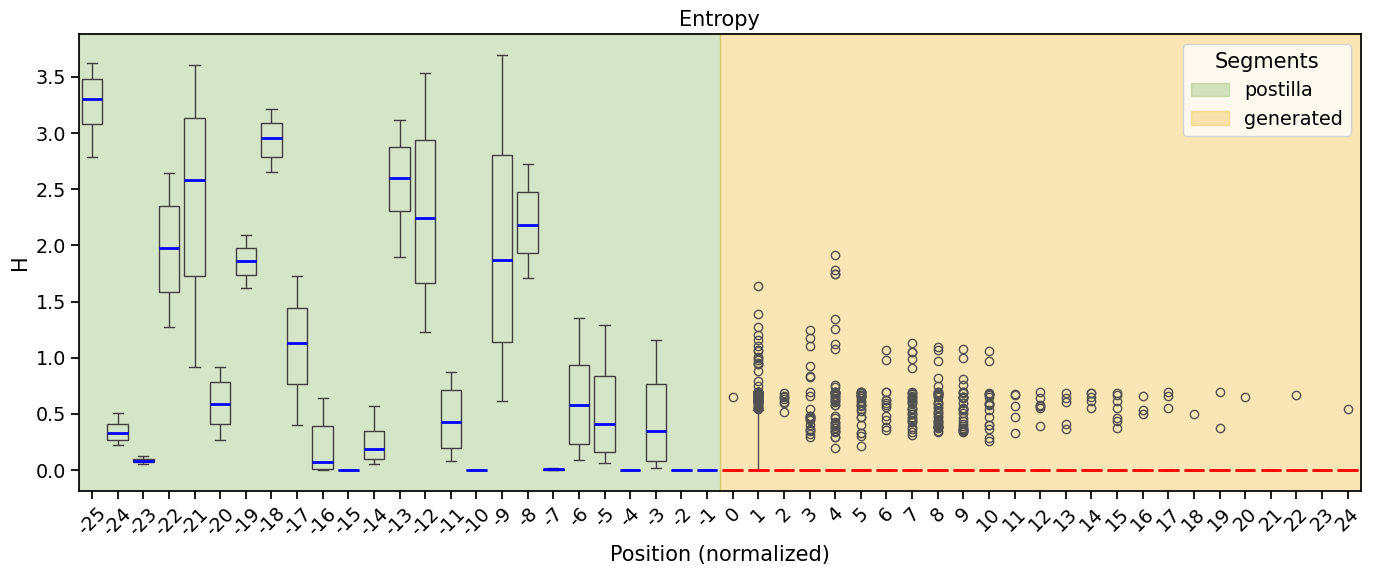

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [97]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_6528/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_6528/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


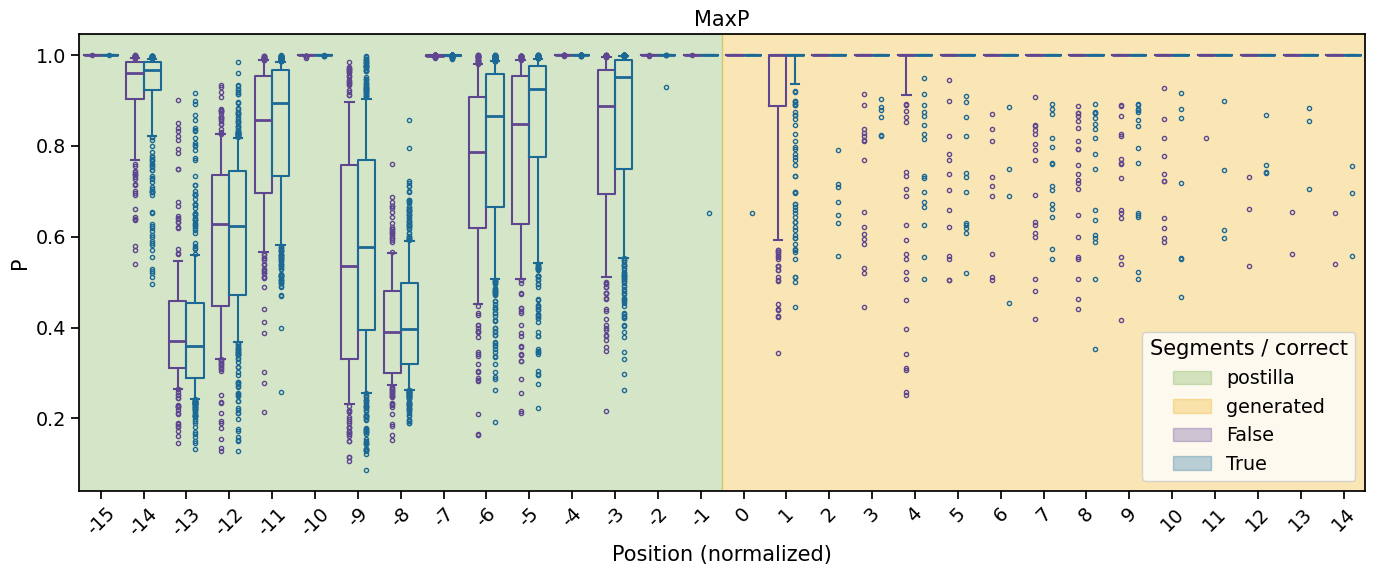

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [158]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

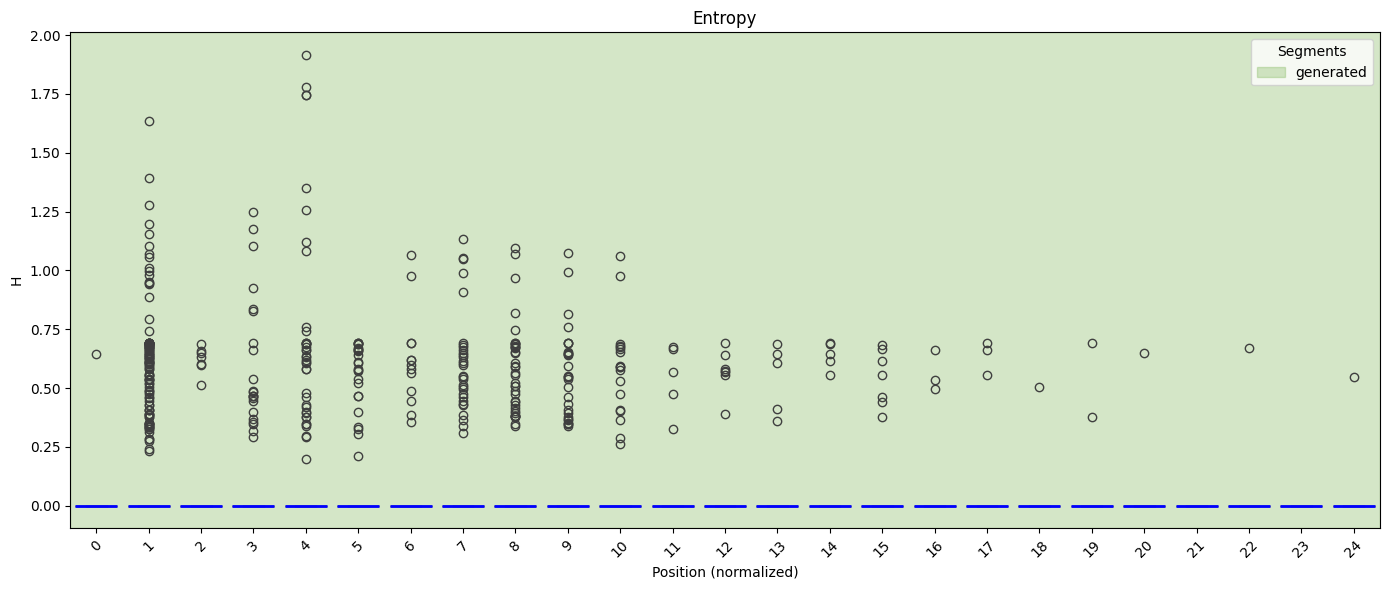

In [56]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [57]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [58]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [59]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [60]:
m[m.segment=='input'].groupby('pid').size().std()

1573.576576615972

In [61]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.9572453

In [62]:
df[df.tok_bin_idx==0].true_ent.var()

10.00165

100


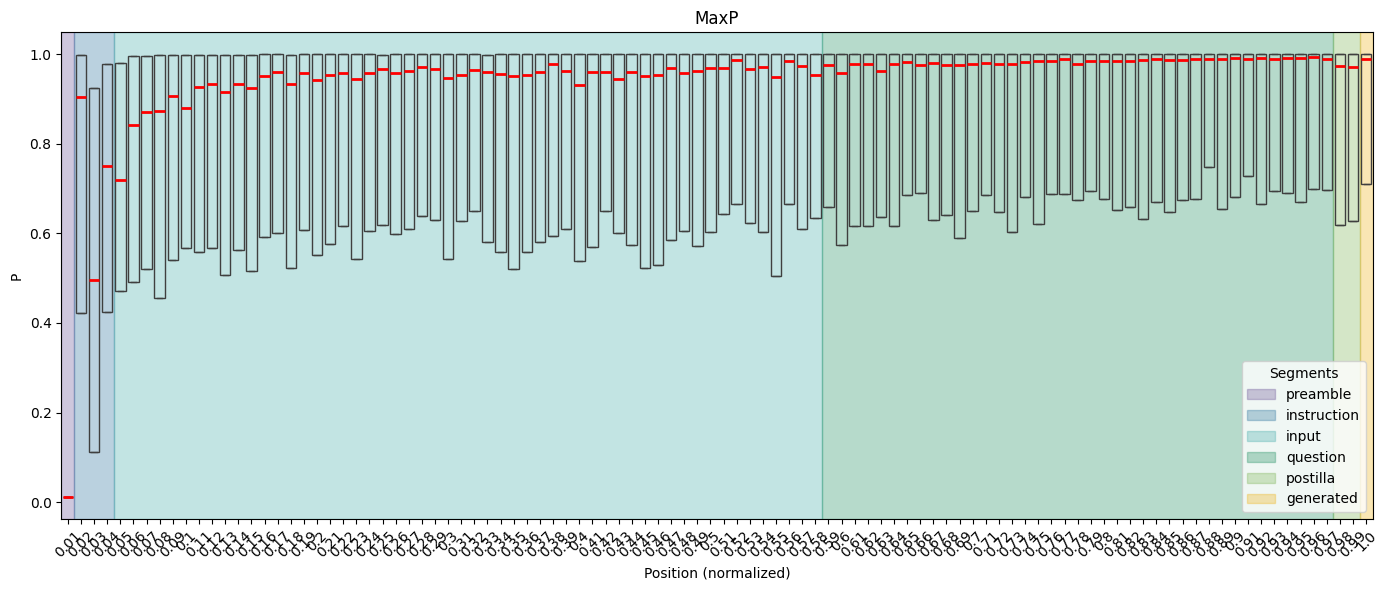

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

100


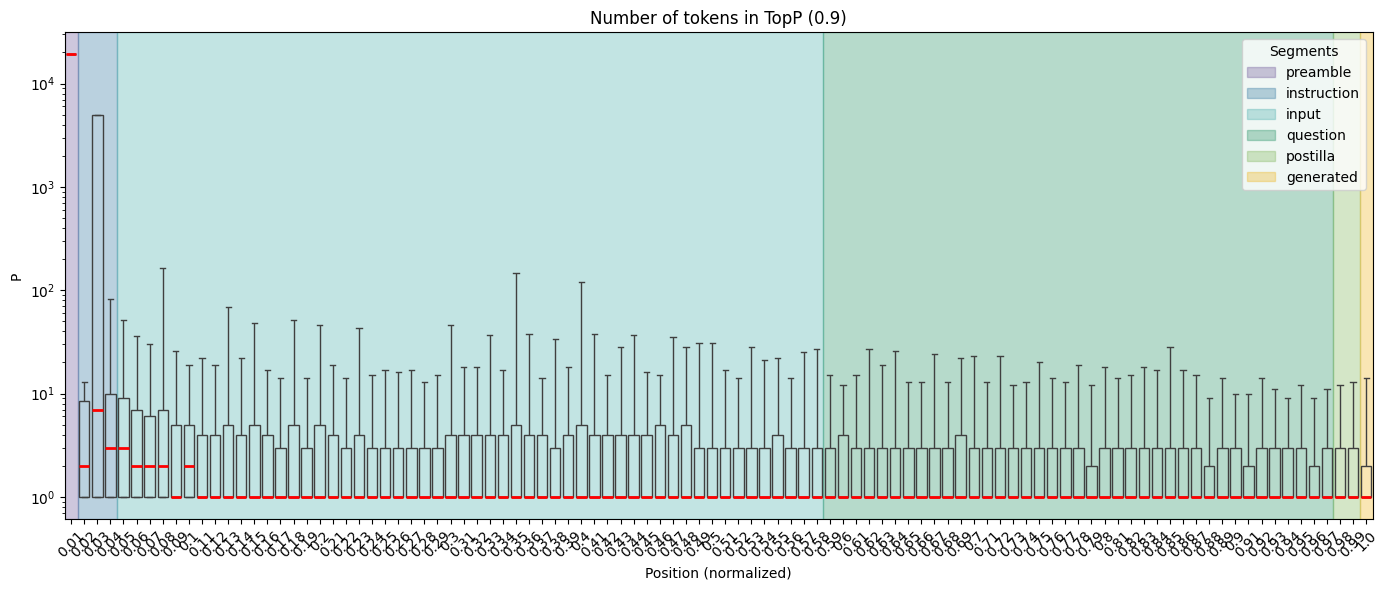

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [148]:
mm[mm.area=='prompt'].true_ent.describe()

count    9.097632e+06
mean     7.961513e-01
std      1.202175e+00
min      0.000000e+00
25%      1.045520e-03
50%      1.538483e-01
75%      1.183405e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [149]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,0.000000,0.000000,0
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,0.025000,0.025000,1
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,0.050000,0.050000,2
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,0.075000,0.075000,3
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,0.100000,0.100000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55012031,6,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999271,5.826087,19
55012037,6,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999453,5.869565,20
55012043,6,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999636,5.913043,21
55012049,6,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999818,5.956522,22


In [150]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [151]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [152]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [153]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

17.60128

In [154]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

102.75

In [155]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

3.6291038012807535

In [156]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [157]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [158]:
mv = mm[mm.pid.isin(variators)]

In [159]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([   9,   14,   17,   18,   45,  128,  130,  164,  238,  298,  300,
        311,  320,  368,  382,  391,  394,  446,  458,  482,  484,  516,
        521,  533,  584,  632,  633,  698,  718,  741,  753,  766,  785,
        805,  829,  839,  854,  879,  880,  884,  886,  902,  928,  952,
        998, 1009, 1011, 1017, 1029, 1034, 1044, 1069, 1070, 1071, 1099,
       1116, 1123, 1140, 1142, 1149, 1160, 1191, 1212, 1245, 1329, 1376,
       1423, 1431, 1489, 1523, 1561, 1582, 1602, 1643, 1644])

In [160]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [161]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([   9,   10,   12,   14,   17,   18,   23,   41,   45,   63,   74,
         79,   85,   86,   89,   94,   99,  109,  112,  119,  123,  125,
        128,  130,  134,  137,  138,  139,  149,  164,  177,  181,  182,
        187,  188,  190,  194,  195,  200,  208,  209,  216,  218,  221,
        224,  229,  238,  265,  269,  270,  278,  279,  288,  292,  297,
        298,  300,  302,  307,  308,  310,  311,  312,  318,  320,  328,
        329,  330,  344,  352,  359,  364,  367,  368,  374,  382,  385,
        388,  391,  394,  398,  403,  404,  408,  409,  421,  440,  442,
        446,  453,  454,  457,  458,  474,  476,  481,  482,  484,  486,
        492,  493,  496,  507,  511,  516,  518,  521,  533,  556,  558,
        561,  565,  583,  584,  590,  592,  607,  613,  614,  621,  627,
        628,  629,  632,  633,  639,  658,  662,  667,  682,  694,  698,
        699,  708,  711,  715,  717,  718,  719,  723,  725,  728,  731,
        741,  743,  753,  757,  758,  766,  768,  7

In [162]:
set(v1) - set(v2)

set()

In [163]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,9,0.25
3,14,0.00
4,17,0.75
5,18,0.75
14,45,0.00
...,...,...
595,1561,0.00
601,1582,0.75
612,1602,0.25
632,1643,0.75


In [164]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct
13,41,0.75
20,63,0.50
25,74,0.25
32,89,0.75
37,99,0.75
...,...,...
668,1750,0.75
669,1751,0.75
679,1775,0.50
680,1776,0.75


In [165]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero,tok_bin,tok_bin_hi,tok_bin_lo,tokzero_end
38831,0,9,6471,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995079,5.000000,0,"(4.98, 5.04]",5.04,4.98,-33
38837,0,9,6472,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995233,5.031250,1,"(4.98, 5.04]",5.04,4.98,-32
38843,0,9,6473,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995387,5.062500,2,"(5.04, 5.1]",5.10,5.04,-31
38849,0,9,6474,generated,2,0.692385,0.519521,6471,6503,generated,5,0.995541,5.093750,3,"(5.04, 5.1]",5.10,5.04,-30
38855,0,9,6475,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995694,5.125000,4,"(5.1, 5.16]",5.16,5.10,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13753049,0,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999271,5.826087,19,"(5.82, 5.88]",5.88,5.82,-5
13753055,0,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999453,5.869565,20,"(5.82, 5.88]",5.88,5.82,-4
13753061,0,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999636,5.913043,21,"(5.88, 5.94]",5.94,5.88,-3
13753067,0,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999818,5.956522,22,"(5.94, 6.0]",6.00,5.94,-2


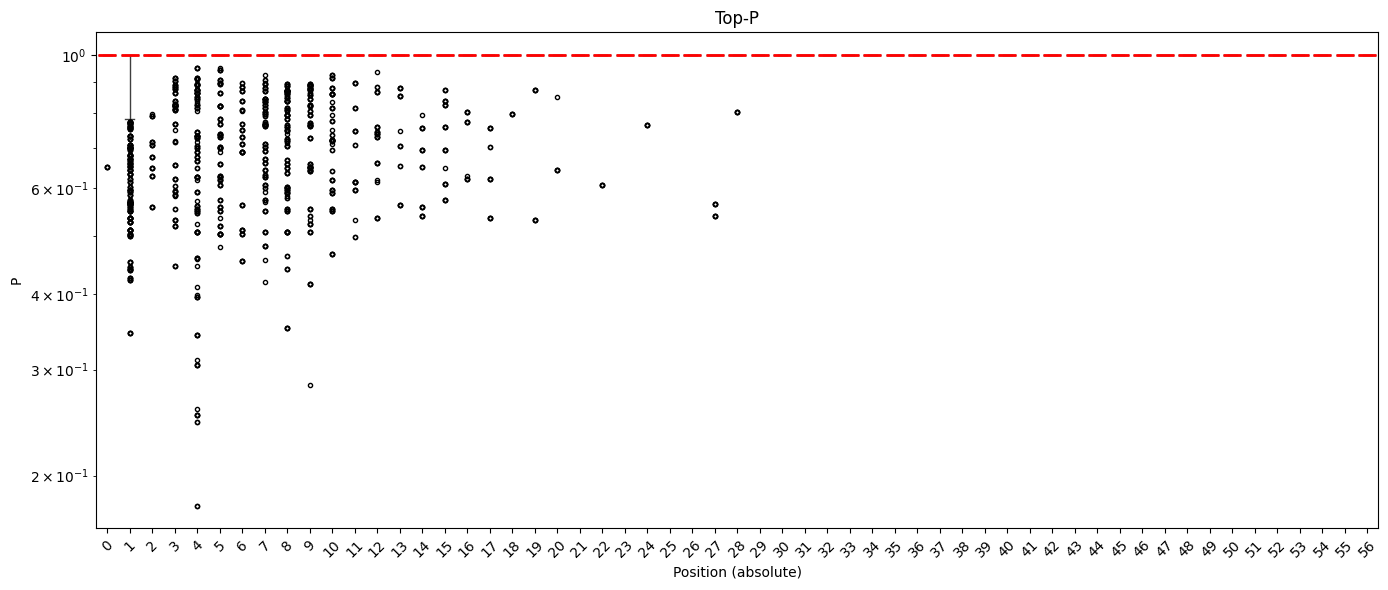

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

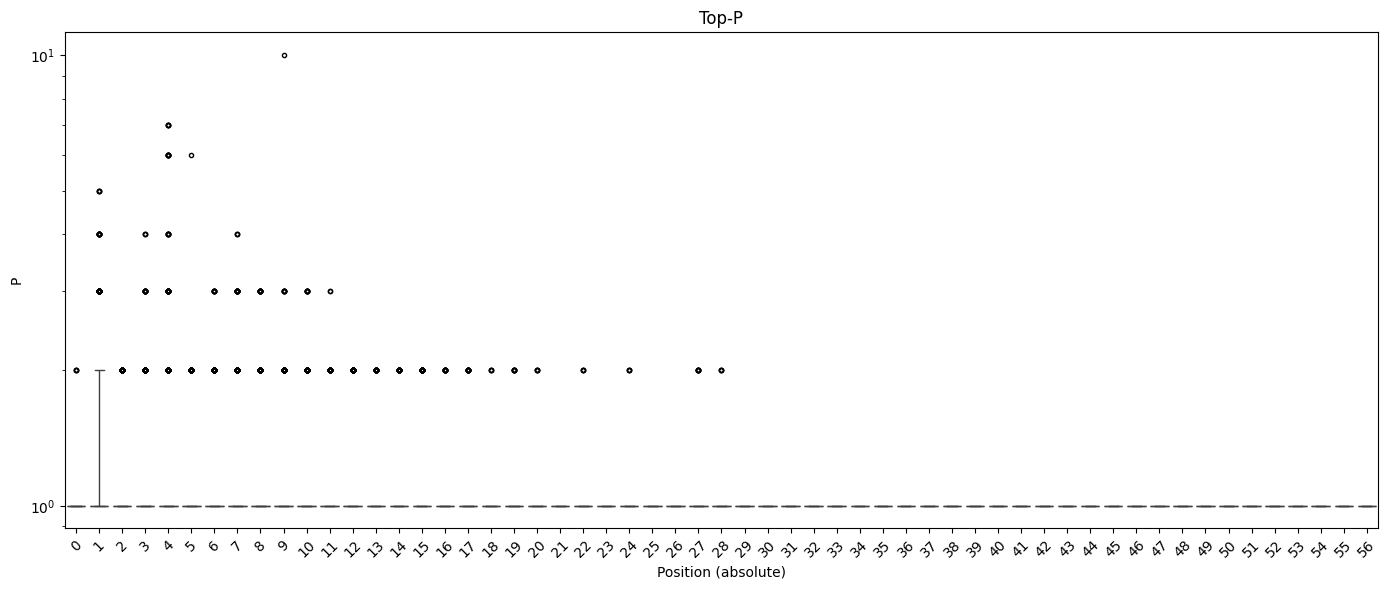

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [168]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero
38831,0,9,6471,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995079,5.000000,0
38837,0,9,6472,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995233,5.031250,1
38843,0,9,6473,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995387,5.062500,2
38849,0,9,6474,generated,2,0.692385,0.519521,6471,6503,generated,5,0.995541,5.093750,3
38855,0,9,6475,generated,1,0.000000,1.000000,6471,6503,generated,5,0.995694,5.125000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55012031,6,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999271,5.826087,19
55012037,6,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999453,5.869565,20
55012043,6,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999636,5.913043,21
55012049,6,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,0.999818,5.956522,22


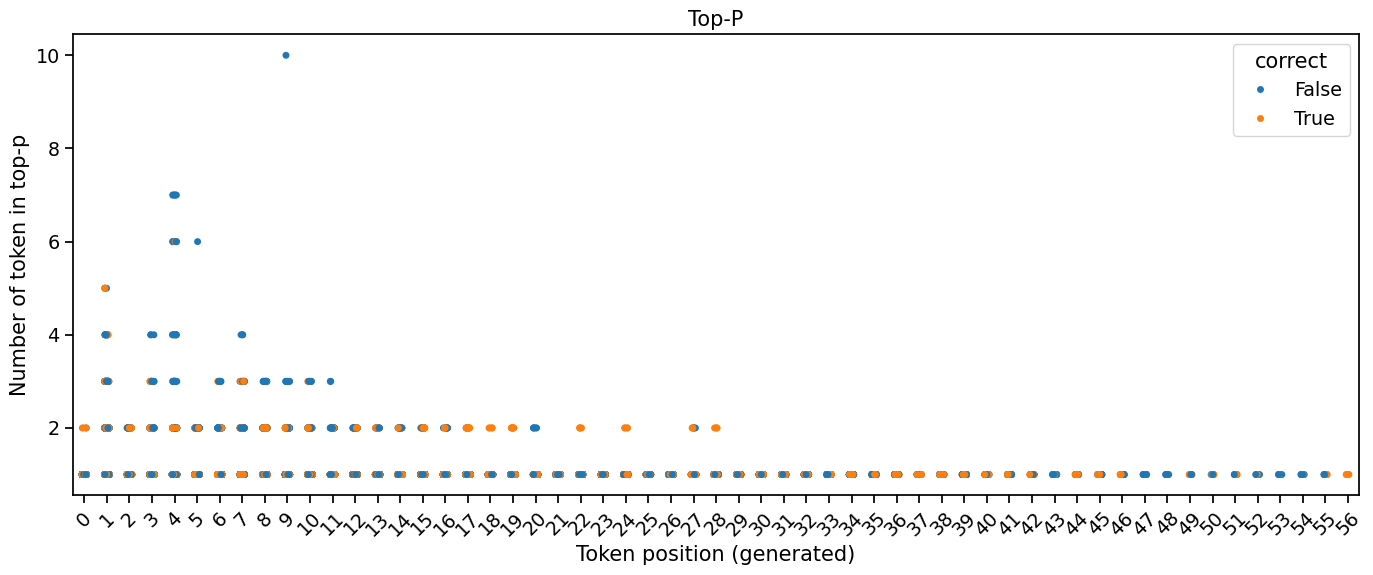

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [160]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,69568,0.683159
2,1292,0.483746
3,138,0.326087
4,26,0.115385
5,4,0.500000
6,10,0.200000
7,5,0.000000
10,1,0.000000


In [177]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.979224
2     0.018186
3     0.001942
4     0.000366
5     0.000056
6     0.000141
7     0.000070
10    0.000014
Name: correct, dtype: float64

In [69]:
mm[mm.segment=='generated'].true_ent.describe()

count    25681.000000
mean         0.006194
std          0.061716
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.133273
Name: true_ent, dtype: float64

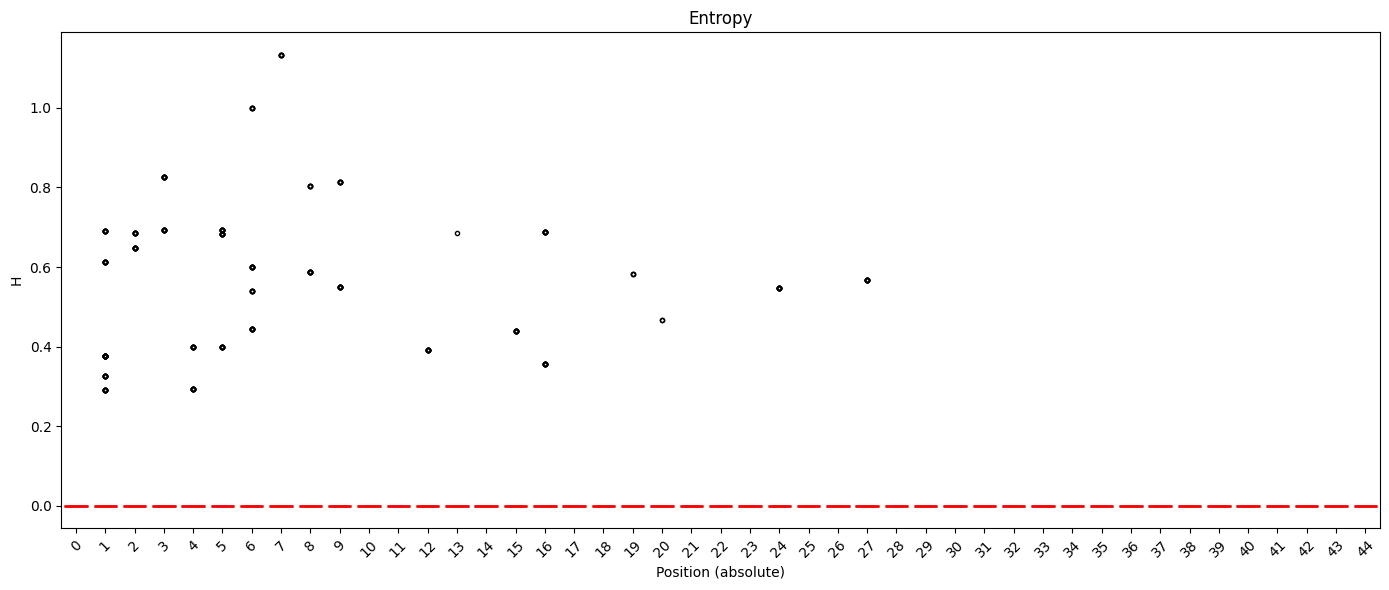

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

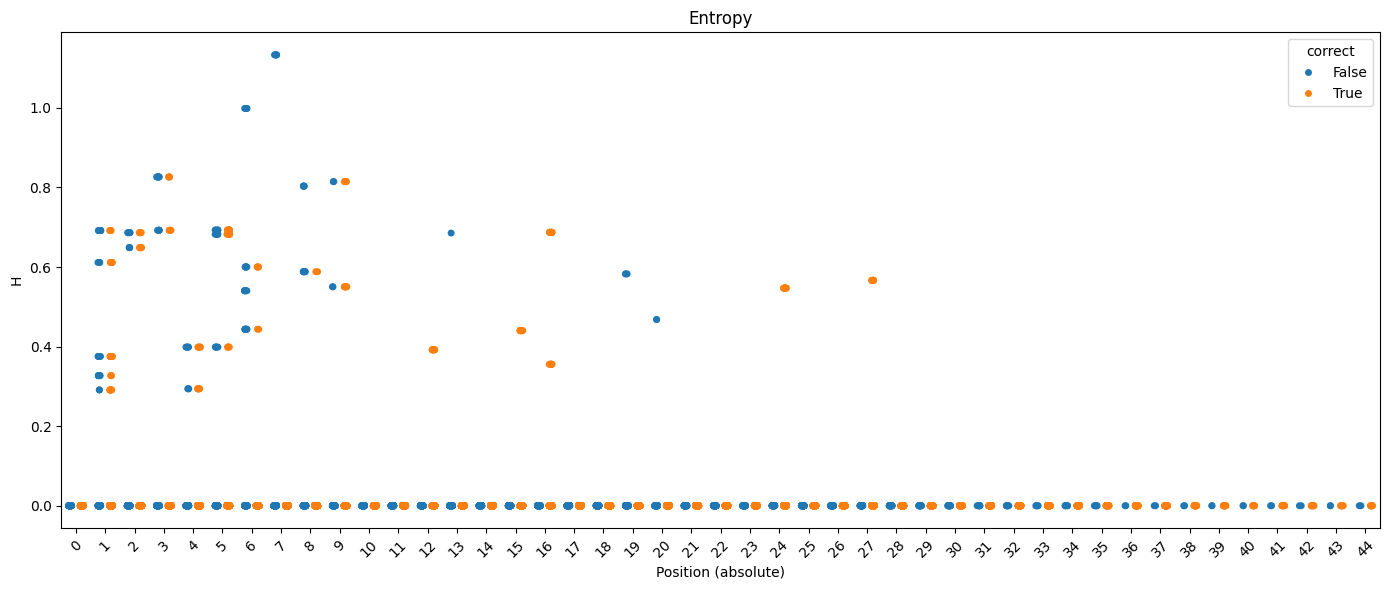

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [72]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero
24167,0,1,1960,generated,1,0.0,1.0,1960,1982,generated,5,0.988900,5.000000,0
24173,0,1,1961,generated,1,0.0,1.0,1960,1982,generated,5,0.989405,5.045455,1
24179,0,1,1962,generated,1,0.0,1.0,1960,1982,generated,5,0.989909,5.090909,2
24185,0,1,1963,generated,1,0.0,1.0,1960,1982,generated,5,0.990414,5.136364,3
24191,0,1,1964,generated,1,0.0,1.0,1960,1982,generated,5,0.990918,5.181818,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20853701,9,1,1978,generated,1,0.0,1.0,1960,1982,generated,5,0.997982,5.818182,18
20853707,9,1,1979,generated,1,0.0,1.0,1960,1982,generated,5,0.998486,5.863636,19
20853713,9,1,1980,generated,1,0.0,1.0,1960,1982,generated,5,0.998991,5.909091,20
20853719,9,1,1981,generated,1,0.0,1.0,1960,1982,generated,5,0.999495,5.954545,21


In [73]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,tok_rel_segm,tok_rel_segm_abs,tokzero
38351,0,2,2341,generated,1,0.0,1.0,2341,2372,generated,5,0.986931,5.000000,0
38357,0,2,2342,generated,1,0.0,1.0,2341,2372,generated,5,0.987352,5.032258,1
38363,0,2,2343,generated,1,0.0,1.0,2341,2372,generated,5,0.987774,5.064516,2
38369,0,2,2344,generated,1,0.0,1.0,2341,2372,generated,5,0.988196,5.096774,3
38375,0,2,2345,generated,1,0.0,1.0,2341,2372,generated,5,0.988617,5.129032,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20867939,9,2,2368,generated,1,0.0,1.0,2341,2372,generated,5,0.998314,5.870968,27
20867945,9,2,2369,generated,1,0.0,1.0,2341,2372,generated,5,0.998735,5.903226,28
20867951,9,2,2370,generated,1,0.0,1.0,2341,2372,generated,5,0.999157,5.935484,29
20867957,9,2,2371,generated,1,0.0,1.0,2341,2372,generated,5,0.999578,5.967742,30


In [74]:
mm.shape

(3857291, 14)

In [75]:
m.shape

(385715, 17)

In [76]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [77]:
# TODO: compare observables grouping by truth

In [181]:
# TODO: plot truth vs aggregated uncertainty

### classifier

In [172]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [173]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [174]:
# beginning of generation

ds = mm[(mm.segment=='generated') & (mm.tokzero<=14)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds

,run,pid,tokzero,shape,true_ent,maxp
38831,0,9,0,1,0.000000,1.000000
38837,0,9,1,1,0.000000,1.000000
38843,0,9,2,1,0.000000,1.000000
38849,0,9,3,2,0.692385,0.519521
38855,0,9,4,1,0.000000,1.000000
...,...,...,...,...,...,...
55011977,6,1797,10,1,0.000000,1.000000
55011983,6,1797,11,1,0.000000,1.000000
55011989,6,1797,12,1,0.000000,1.000000
55011995,6,1797,13,1,0.000000,1.000000


In [175]:
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [176]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,...,true_ent6,true_ent7,true_ent8,true_ent9,true_ent10,true_ent11,true_ent12,true_ent13,true_ent14,correct
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,...,0.000000,1.133273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,0,12,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0.600141,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,0,14,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,...,0.000000,1.052806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,0,17,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,6,1788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2748,6,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2749,6,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2750,6,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [177]:
# shuffle for randomism (groupkfold does not have shuffle in the installed version)
# ds = ds.sample(frac=1).reset_index(drop=True)

In [178]:
ds.correct.value_counts()

correct
True     1887
False     865
Name: count, dtype: int64

In [179]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct'])

In [180]:
X.loc[:,X.nunique()!=1].shape

(2752, 45)

### beginning of generation

In [181]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

CPU times: user 4min 5s, sys: 16.1 s, total: 4min 21s
Wall time: 33 s


In [182]:
from sklearn.metrics import classification_report

pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y.values, pred))

              precision    recall  f1-score   support

       False       0.61      0.31      0.41       865
        True       0.74      0.91      0.82      1887

    accuracy                           0.72      2752
   macro avg       0.68      0.61      0.61      2752
weighted avg       0.70      0.72      0.69      2752



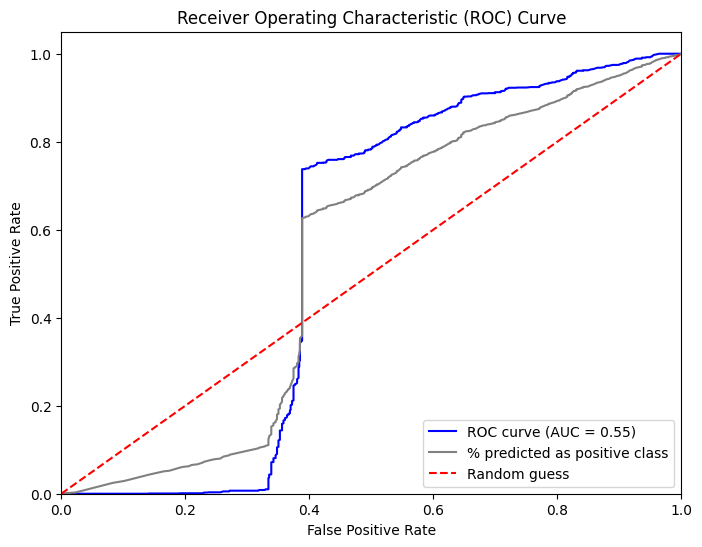

In [183]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [184]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

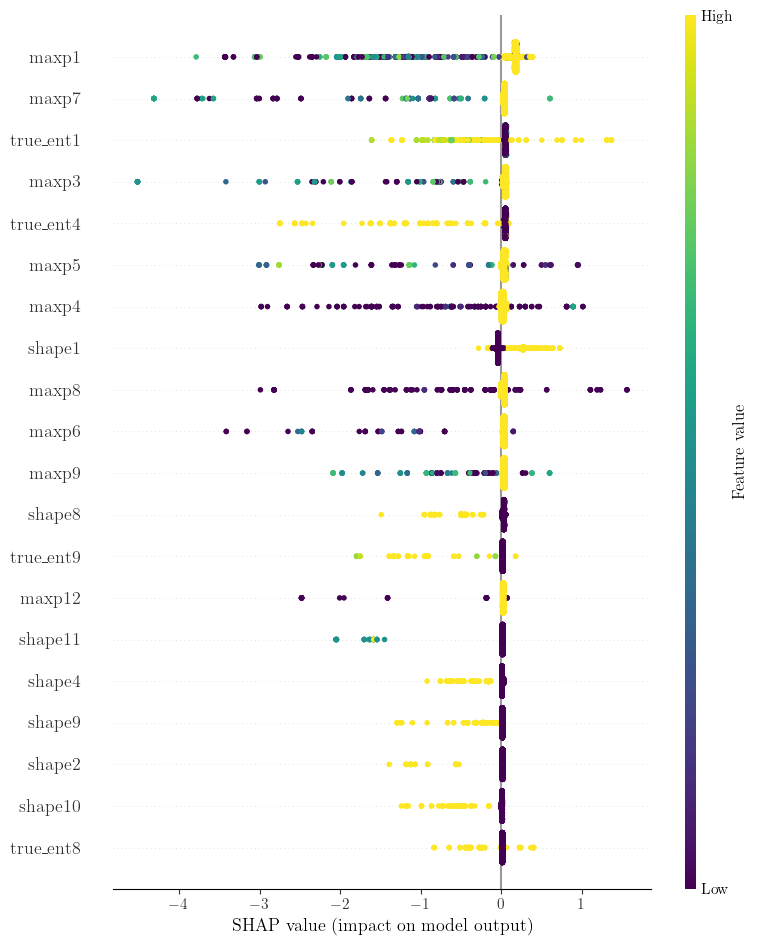

In [204]:
shap.summary_plot(shap_values, X, cmap="viridis")

In [200]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))

In [202]:
vals.groupby('grp').value.sum()

grp
maxp        0.619321
shape       0.194887
true_ent    0.185792
Name: value, dtype: float64

### end of postilla

In [205]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [209]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct'])
X.columns = ['postilla_'+col for col in X.columns]

In [210]:
ds

,run,pid,shape-65,shape-64,shape-63,shape-62,shape-61,shape-60,shape-59,shape-58,...,true_ent-9,true_ent-8,true_ent-7,true_ent-6,true_ent-5,true_ent-4,true_ent-3,true_ent-2,true_ent-1,correct
0,0,9,15.0,3.0,17.0,14.0,1.0,1.0,3.0,13.0,...,3.143889,1.916711,0.010578,1.914055,1.797993,0.000239,0.778824,0.000057,6.776936e-06,False
1,0,10,9.0,5.0,8.0,16.0,1.0,1.0,4.0,12.0,...,3.529437,1.482318,0.016156,0.740798,0.761440,0.000157,0.240973,0.000012,9.915550e-07,False
2,0,12,5.0,5.0,19.0,14.0,8.0,3.0,3.0,96.0,...,1.358079,2.591903,0.005839,0.318298,0.256653,0.000155,0.285100,0.000010,0.000000e+00,False
3,0,14,14.0,5.0,31.0,14.0,7.0,1.0,7.0,26.0,...,1.625746,2.564083,0.004681,0.128516,0.089848,0.000300,0.361298,0.000012,2.019689e-06,False
4,0,17,16.0,4.0,27.0,18.0,9.0,2.0,6.0,117.0,...,1.957023,2.397525,0.007099,0.877921,1.137557,0.000244,1.727326,0.000087,1.308782e-05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,6,1788,2.0,5.0,11.0,23.0,3.0,1.0,6.0,43.0,...,1.588344,1.954940,0.039551,0.081567,0.115607,0.000637,0.025251,0.000008,0.000000e+00,True
2748,6,1789,11.0,4.0,18.0,18.0,1.0,1.0,7.0,23.0,...,3.118942,2.479716,0.005155,0.977768,0.673445,0.000188,0.716020,0.000008,0.000000e+00,True
2749,6,1790,7.0,4.0,19.0,13.0,1.0,1.0,4.0,20.0,...,2.961254,2.265612,0.021245,1.291602,0.630686,0.000455,0.696871,0.000044,4.865674e-06,False
2750,6,1794,3.0,5.0,10.0,21.0,6.0,1.0,4.0,43.0,...,4.042446,3.115464,0.010870,0.602034,0.790274,0.000107,0.200622,0.000047,6.776936e-06,True


In [211]:
X.shape

(2752, 195)

In [125]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_instr = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

In [130]:
pred_proba.shape

(2752, 2)

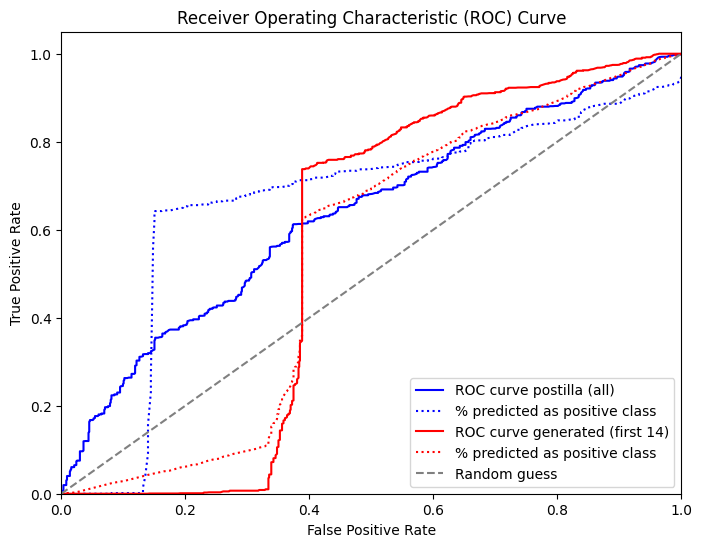

In [153]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [114]:
len(thresholds)

455

In [212]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

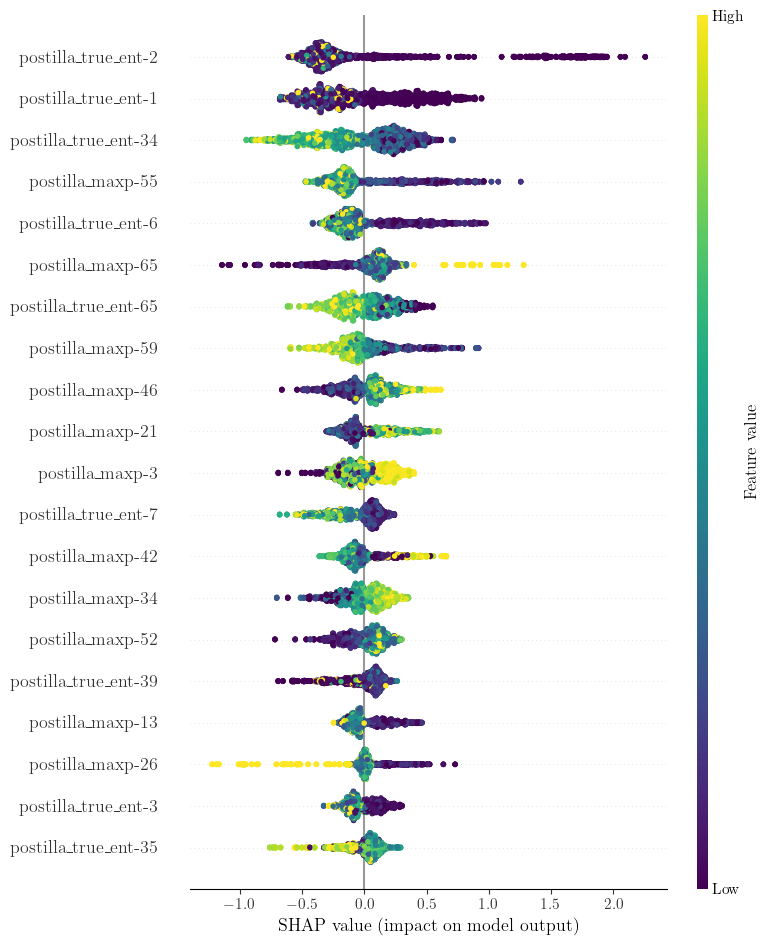

In [213]:
shap.summary_plot(shap_values, X, cmap="viridis")

In [214]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))

In [215]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.450139
postilla_shape-       0.096408
postilla_true_ent-    0.453453
Name: value, dtype: float64

### combo

In [161]:
# COMBO
# beginning of generate

ds = mm[(mm.segment=='generated') & (mm.tokzero<=14)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds1 = ds.merge(truth, on=['run', 'pid'])

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])

In [165]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct'])

In [166]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,...,true_ent-10,true_ent-9,true_ent-8,true_ent-7,true_ent-6,true_ent-5,true_ent-4,true_ent-3,true_ent-2,true_ent-1
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,...,0.000142,3.143889,1.916711,0.010578,1.914055,1.797993,0.000239,0.778824,0.000057,6.776936e-06
1,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000077,3.529437,1.482318,0.016156,0.740798,0.761440,0.000157,0.240973,0.000012,9.915550e-07
2,0,12,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0.000173,1.358079,2.591903,0.005839,0.318298,0.256653,0.000155,0.285100,0.000010,0.000000e+00
3,0,14,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,...,0.000278,1.625746,2.564083,0.004681,0.128516,0.089848,0.000300,0.361298,0.000012,2.019689e-06
4,0,17,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.000303,1.957023,2.397525,0.007099,0.877921,1.137557,0.000244,1.727326,0.000087,1.308782e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,6,1788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000187,1.588344,1.954940,0.039551,0.081567,0.115607,0.000637,0.025251,0.000008,0.000000e+00
2748,6,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000687,3.118942,2.479716,0.005155,0.977768,0.673445,0.000188,0.716020,0.000008,0.000000e+00
2749,6,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000213,2.961254,2.265612,0.021245,1.291602,0.630686,0.000455,0.696871,0.000044,4.865674e-06
2750,6,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000174,4.042446,3.115464,0.010870,0.602034,0.790274,0.000107,0.200622,0.000047,6.776936e-06


In [168]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct'])

In [169]:
X.shape

(2752, 240)

In [170]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')

CPU times: user 31min 49s, sys: 2min 16s, total: 34min 5s
Wall time: 4min 42s


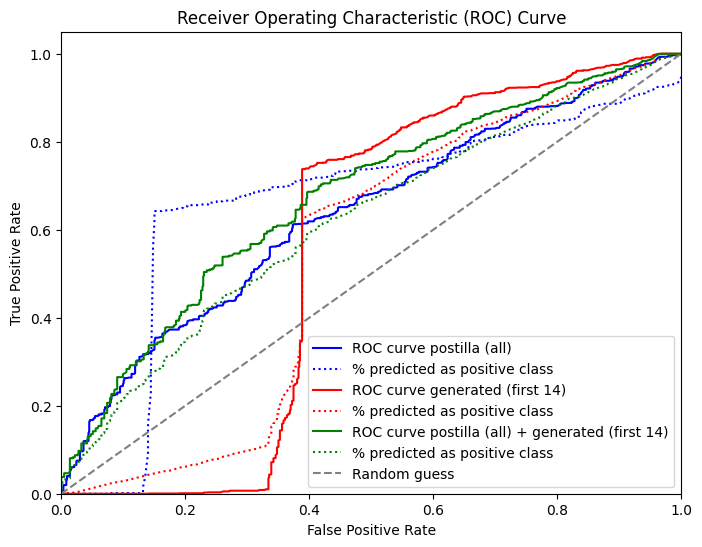

In [171]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()